# Expectation-Maximization (EM) Algorithm
### Implementation and visualization of the EM algorithm.

In [43]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# plot styling
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'DIN Alternate'

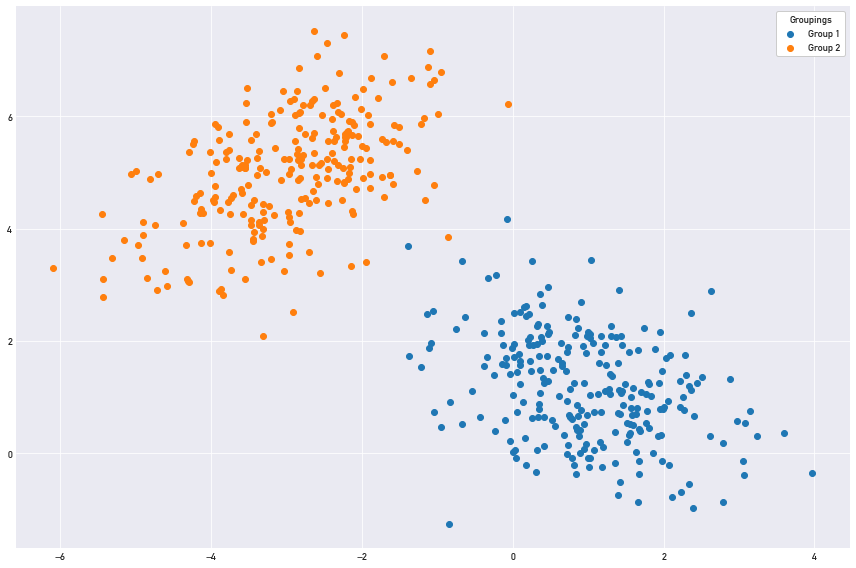

In [44]:
# simulate some data
n = 250
group_1 = np.random.multivariate_normal([1, 1], [[1, -.4], [-.4, 1]], size=n)
group_2 = np.random.multivariate_normal([-3, 5], [[1, .5], [.5, 1]], size=n)
plt.scatter(group_1[:, 0], group_1[:, 1], label='Group 1')
plt.scatter(group_2[:, 0], group_2[:, 1], label='Group 2')
plt.legend(frameon=1, framealpha=1, facecolor='white', title='Groupings')
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [45]:
def init_cov(n):
    """ Generate initial covariance matrix """
    # ensures positive semi-definiteness
    x = np.random.standard_normal((n, n))
    return np.dot(x, x.T)

In [46]:
def init_guess(n):
    """ Generates initial guess for all parameters """
    return {
        'pi': np.random.uniform(0, 1),
        'mu_1': np.random.standard_normal((n, )),
        'mu_2': np.random.standard_normal((n, )),
        'S_1': init_cov(n),
        'S_2': init_cov(n)
    }

In [47]:
def get_posteriors(x, p):
    """ Compute the posteriors """
    p_1 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x)
    p_2 = multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1 = p['pi']
    pi_2 = 1 - pi_1
    P_1, P_2 = p_1 * pi_1, p_2 * pi_2
    Q_1 = P_1 / (P_1 + P_2)
    Q_2 = P_2 / (P_1 + P_2)
    return np.array([Q_1, Q_2]).T
    

In [48]:
def e_step(x, p):
    """ Compute expectation step """
    p_1 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x)
    p_2 = multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1 = p['pi']
    pi_2 = (1 - p_1)
    return np.mean(np.log(pi_1 * p_1 + pi_2 * p_2)), get_posteriors(x, p)

In [63]:
def m_step(x, p):
    """ Compute maximization step """
    N = x.shape[0]
    _, post = e_step(x, p)
    post_1, post_2 = post[:, 0].reshape((N, 1)), post[:, 1].reshape((N, 1))
    tot_post_1, tot_post_2 = np.sum(post_1), np.sum(post_2)
    pi_1 = tot_post_1 / N
    mu_1 = (post_1.T.dot(x) / tot_post_1).flatten()
    mu_2 = (post_2.T.dot(x) / tot_post_2).flatten()
    D_1, D_2 = x - mu_1, x - mu_2
    S_1 = D_1.T.dot(D_1 * post_1) / tot_post_1
    S_2 = D_2.T.dot(D_2 * post_2) / tot_post_2
    return {
        'pi': pi_1,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'S_1': S_1,
        'S_2': S_2
    }

In [64]:
def run_em(x, p, tol=10e-8):
    converged = False
    while not converged:
        previous_loglik, _ = e_step(x, p)
        p = m_step(x, p)
        current_loglik, _ = e_step(x, p)
        if np.abs(previous_loglik - current_loglik) < tol:
            converged = True
    return p

In [65]:
def plot_cov_ellipse(mu, cov, ax, n_std=3, facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2,
    height=ell_radius_y * 2, facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [66]:
# stack data
dat = np.concatenate([group_1, group_2], axis=0)
dat.shape

# generate initial guess
g = init_guess(2)

# run EM-algorithm!
res = run_em(dat, g)

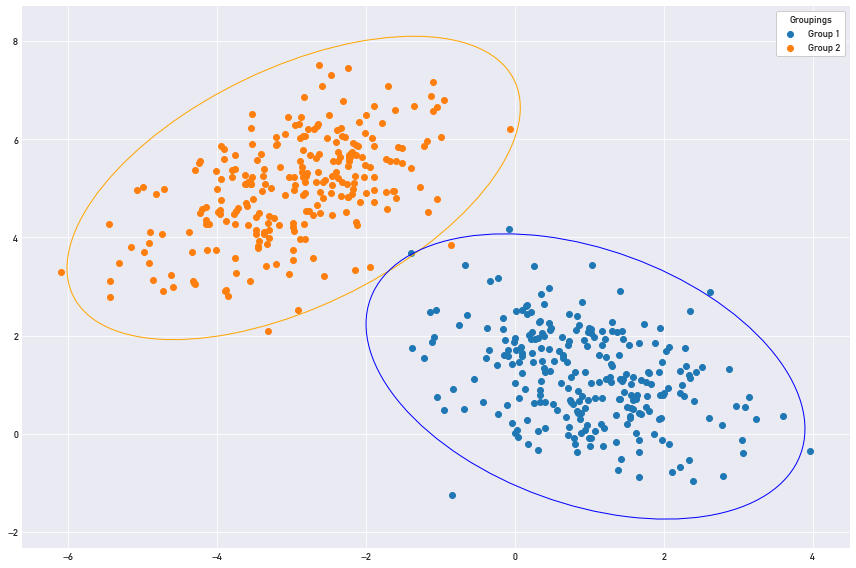

In [69]:
# visualization of clusters by EM algorithm
plt.scatter(group_1[:, 0], group_1[:, 1], label='Group 1')
plt.scatter(group_2[:, 0], group_2[:, 1], label='Group 2')
ax = plt.gca()
plot_cov_ellipse(res['mu_1'], res['S_1'], ax=ax, edgecolor='orange')
plot_cov_ellipse(res['mu_2'], res['S_2'], ax=ax, edgecolor='blue')
plt.legend(frameon=1, framealpha=1, facecolor='white', title='Groupings')
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()